# Prospecção de Dados (Data Mining) DI/FCUL - HA3

## Third Home Assignement (MC/DI/FCUL - 2024)

### Fill in the section below

### GROUP:`5`

* Paulo Lopes, 54348 - 5
* Simona Losco, 62523 - 5
* Sona Moravcikova, 62932 - 5




The purpose of this Home Assignment is
* Find similar items with Local Sensitivity Hashing
* Do Dimensionality Reduction

**NOTE 1: Students are not allowed to add more cells to the notebook**

**NOTE 2: The notebook must be submited fully executed**

**NOTE 3: Name of notebook should be: HA3_GROUP-XX.ipynb (where XX is the group number)**



## 1. Read the Dataset

The dataset correspond to about 99% of the Human Proteome (set of known Human Proteins - about 19,500), coded with specific structural elements. They are presented in a dictionary where the key is the [UniprotID](https://www.uniprot.org/) of the protein and the value is a set of indices of a specific structural characteristic

Students can use one of two datasets, that are **not** subsets of each other: 
* `data_d3.pickle` - smaller set of structural features (2048)
* `data_d4.pickle` - much larger set of structural features (20736) **Note:** This dataset has been Zipped to fit into moodle. Students should unzip it before usage 

Select **one** of the datasets and perform all analyses with it. 

It may be adviseable the usage of sparse matrices, especially for the `d4` dataset



In [3]:
### Your code Here
import pickle
import pandas as pd
from scipy import sparse
from scipy.sparse import csr_matrix
import numpy as np


with open("data_d4.pickle", "rb") as fh:
    data = pickle.load(fh)

# Extracting unique features for sparse matrix dims
all_feats = set()
for feats_set in data.values():
    all_feats.update(feats_set)

n_feats = max(all_feats) + 1  # 0-based indexing

# Creating sparse matrix
rows, cols = [], []
for i, (uniprot_id, feats_set) in enumerate(data.items()):
    rows.extend([i] * len(feats_set))
    cols.extend(feats_set)

sparse_mat = csr_matrix((np.ones(len(rows)), (rows, cols)), shape=(len(data), n_feats))

# features x proteins
sparse_mat = sparse_mat.T

prot_names = list(data.keys())

## 2. Perform Local Sensitivity Hashing (LSH)

* examine the selected dataset in terms of similarities and select a set of LSH parameters able to capture the most similar proteins
* Comment your results

**BONUS POINTS:** It might be interesting to identify **some** of the candidate pairs in Uniprot, to check if they share some of the same properties (e.g. for [protein P28223](https://www.uniprot.org/uniprotkb/P28223/entry))


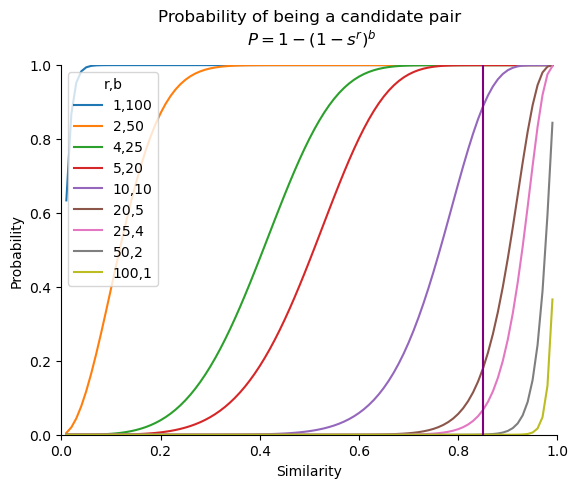

In [26]:
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

### Add supporting functions here


### permutation hash function
def create_hash(vector_size=sparse_mat.shape[0]):
    return np.random.permutation(vector_size)


def get_signature_matrix(sparse_mat, sig_size=50):
    permutations = np.zeros((sparse_mat.shape[0], sig_size), dtype=int)
    for i in range(sig_size):
        permutations[:, i] = create_hash()

    # signature matrix
    signature_matrix = np.zeros((permutations.shape[1], sparse_mat.shape[1]))

    for i in range(permutations.shape[1]):
        perm = permutations[:, i]
        sigs = sparse_mat[perm, :].argmax(axis=0)
        signature_matrix[i, :] = sigs

    return signature_matrix


def split_sig(sig: np.array, b: int):
    return np.vsplit(sig, b)


def hash_bands_to_buckets(bands, num_buckets=1000):

    hashed_bands = {}

    n_bands = len(bands)

    for i in range(n_bands):
        band = bands[i]
        for col in range(band.shape[1]):
            col_hash = hashlib.sha256(band[:, col].tobytes()).hexdigest()
            bucket = int(col_hash, 16) % num_buckets

            if bucket not in hashed_bands.keys():
                hashed_bands[bucket] = set()
            hashed_bands[bucket].add(col)

    return hashed_bands


def jaccard_similarity(ids):
    id1, id2 = ids
    set1 = data[prot_names[id1]]
    set2 = data[prot_names[id2]]
    return len(set1.intersection(set2)) / len(set1.union(set2))


def fetch_pairs(buckets, threshold=0.8):
    candidates = []
    for proteins in buckets.values():
        if len(proteins) > 1 and len(proteins) < 3:
            sim = jaccard_similarity(tuple(proteins))
            if sim >= threshold:
                candidates.append(tuple(proteins))
    return candidates


def probability(s, r, b):
    # s: similarity
    # r: rows (per band)
    # b: number of bands
    return 1 - (1 - s**r) ** b


def sexy_tuning_plot():
    results = []

    for s in np.arange(0.01, 1, 0.01):
        total = 100
        for b in [100, 50, 25, 20, 10, 5, 4, 2, 1]:
            r = int(total / b)
            P = probability(s, r, b)
            results.append({"s": s, "P": P, "r,b": f"{r},{b}"})

    results = pd.DataFrame(results)
    sns.lineplot(data=results, x="s", y="P", hue="r,b")
    plt.axis([0, 1, 0, 1])
    sns.despine()
    plt.title("Probability of being a candidate pair\n $P = 1 - (1 - s^r)^b$", pad=15)
    plt.xlabel("Similarity")
    plt.ylabel("Probability")
    plt.axvline(0.85, color="purple")
    plt.show()


sexy_tuning_plot()

In [24]:
### Add processing code here

SIG = get_signature_matrix(sparse_mat, sig_size=100)

# split signature matrix into bands
b = 10
bands = split_sig(SIG, b)

# hash bands to buckets
buckets = hash_bands_to_buckets(bands, 100000000)

# grab candidate pairs
candidate_pairs = fetch_pairs(buckets, threshold=0.85)

for i in candidate_pairs[:5]:
    print(
        prot_names[i[0]],
        prot_names[i[1]],
        f"Jaccard Similarity: {jaccard_similarity(i):.3f}",
    )
    print()
print("Total candidate pairs:", len(candidate_pairs))

P47813 O14602 Jaccard Similarity: 0.870

Q16777 Q6FI13 Jaccard Similarity: 0.935

Q6ZUB0 P0C874 Jaccard Similarity: 0.885

P0CJ90 P0CJ89 Jaccard Similarity: 0.869

P01593 P01594 Jaccard Similarity: 0.910

Total candidate pairs: 147


### Short analysis 

Analyzing the LSH similarity-probability plot we can tell that there is a trade-off as we select parameters such as threshold, number of bands and number of rows per band. Our signature matrix is composed of 100 rows and the number of columns is the number of proteins. As such, we can tune these parameters according to $P = 1 - (1 - s^r)^b$ that gives us the probability that the signature agree in all the rows of at least one band. We chose 10 bands with 10 rows each as well as the threshold of 85% for similarity, as it amounts to 88% of said probability and ensures we are not being optimistic with our candidate pairs. We identified 147 candidate pairs.  

To verify whether the candidate pairs identified by our LSH method share common properties, we specifically examined pairs P47813 & O14602 and Q16777 & Q6FI13 using UniProt. According to Uniprot, P47813 and O14602 share a lot of the same properties; both are integral in translation initiation, involved in forming the cap-proximal complex, facilitating scanning and start codon recognition, and promoting the assembly of the 48S complex at the initiation codon. Similarly, Q16777 and Q6FI13 are both histones (Histone H2A type 2-C and Histone H2A type 2-A, respectively) and therefore share nearly all structural and functional properties. This confirmation aligns well with the high Jaccard similarities observed, supporting the effectiveness of our LSH method in identifying functionally related proteins.

## 3. Do dimensionality reduction 

Use the techniques discussued in class to make an appropriate dimensional reduction of the selected dataset. It is not necesary to be extensive, **it is better to select one approach and do it well than try a lot of techniques with poor insights and analysis**

It is important to do some sensitivity analysis, relating the dataset size reduction to the loss of information



In [29]:
### Add supporting functions here
from scipy.sparse.linalg import svds

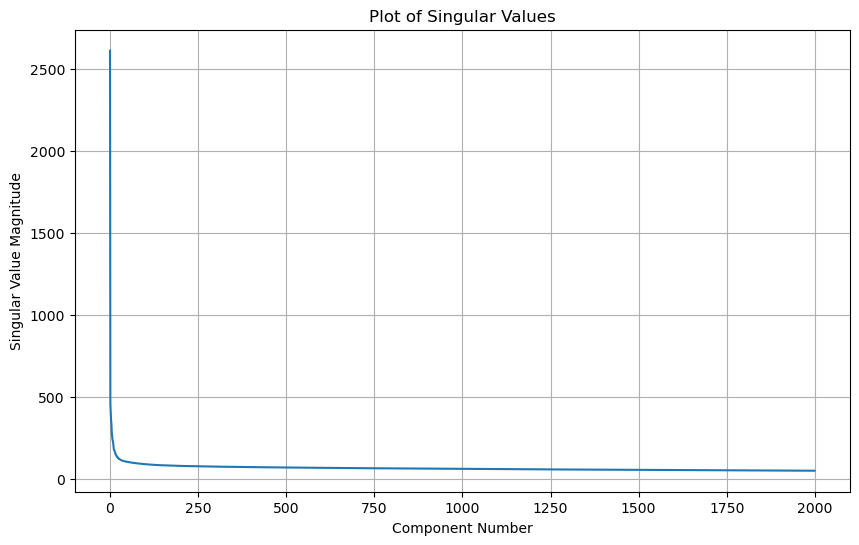

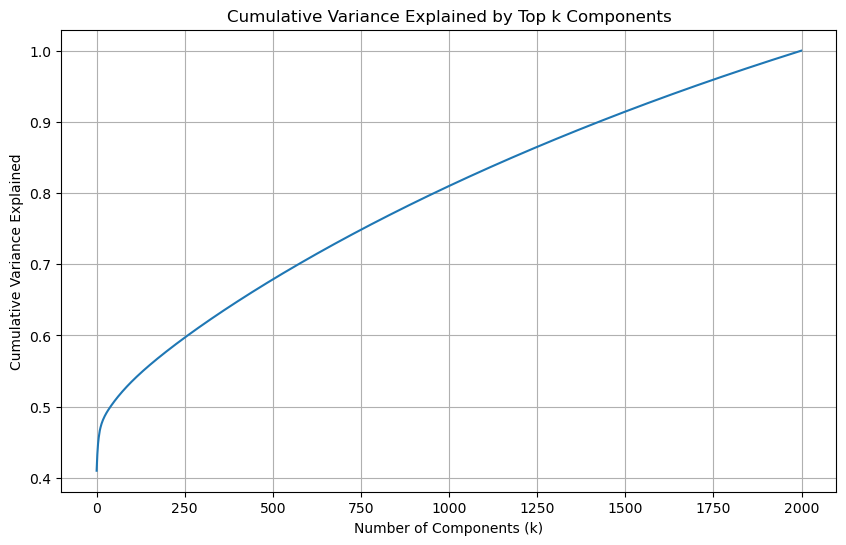

In [36]:
### Add processing code here

# Perform SVD on the sparse matrix
U,S,V  = svds(sparse_mat, k=2000)
S = np.flip(S) # Largest singular values first

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(S)
plt.title('Plot of Singular Values')
plt.xlabel('Component Number')
plt.ylabel('Singular Value Magnitude')
plt.grid(True)
plt.show()

# Calculate total and cumulative variance explained
total_variance = np.sum(S**2)  # Total variance from the singular values
cumulative_variance = np.cumsum(S**2) / total_variance

# Cumulative Variance Explained Plot
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance)
plt.title('Cumulative Variance Explained by Top k Components')
plt.xlabel('Number of Components (k)')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()

## 4. Discuss your findings

* Comment your results above
* Discuss how could they be used for the full Uniprot that currently has about [248 Million proteins](https://www.uniprot.org/uniprotkb/statistics)


The plot of singular values shows a sharp decline in singular value magnitude after the first few components, specifically around 25, indicating that these components capture most of the variability in the data. This pattern is characteristic of datasets where a few principal components capture the majority of the information, and the rest contribute progressively less to the data's structure. However, while these early components individually capture a substantial amount of variance, they do not collectively reach the 80% threshold often considered optimal for a comprehensive representation of the data. To achieve 80% cumulative variance explained—a balance point between dimensionality reduction and information retention—it is necessary to include around 900 components. Although the singular values of these additional components are considerably smaller, their combined contribution is substantial, illustrating that while the initial components provide the most significant individual contributions, a larger number of components are required to capture the finer nuances and subtler structures within the data.

The cumulative variance plot was limited to 2000 components due to computational constraints. However, considering the original size of this dataset (20,736 x 19,258), the analysis demonstrates that a relatively small number of components are required to capture a significant proportion of the dataset's variance. Specifically, reducing the dataset to 900 components captures around 80% of the variance. This suggests that the dataset's intrinsic dimensionality is much lower than its raw feature dimensionality, underscoring the potential efficiency gains from dimensionality reduction.

Therefore, despite the high dimensionality of proteomic data, the underlying biological processes might be represented by a relatively small number of principal components. Dimensionality reduction on the UniProt dataset could facilitate more efficient searches, similarity assessments, and classification tasks by reducing the dataset to its most informative features, thereby significantly reducing computational and storage requirements. This approach could enhance the ability to discover and categorize new proteins or predict their functions, offering profound benefits for biological research and therapeutic development.